In [20]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn.functional as F


In [7]:
# MNIST
train_dataset = dsets.MNIST(root='./data', train=True,
    transform=transforms.ToTensor(), download=True)

test_dataset = dsets.MNIST(root='./data', train=False,
    transform=transforms.ToTensor(), download=False)

In [9]:
batch_size = 32
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

In [22]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # image shape is 1 * 28 * 28, where 1 is one color channel
        # 28 * 28 is the image size
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5)    # output shape = 3 * 24 * 24
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                       # output shape = 3 * 12 * 12
        # intput shape is 3 * 12 * 12
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=9, kernel_size=5)    # output shape = 9 * 8 * 8
        # add another max pooling, output shape = 9 * 4 * 4
        self.fc1 = nn.Linear(9 * 4 * 4, 100)
        self.fc2 = nn.Linear(100, 50)
        # last fully connected layer output should be same as classes
        self.fc3 = nn.Linear(50, 10)
        
    def forward(self, x):
        # first conv
        x = self.pool(F.relu(self.conv1(x)))
        # second conv
        x = self.pool(F.relu(self.conv2(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x
    
model = ConvNet()

In [23]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
# Hyper-parameters
num_epochs = 4
batch_size = 10
learning_rate = 0.001

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [33]:
loss_list = []
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        # init optimizer
        optimizer.zero_grad()
        
        # forward -> backward -> update
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
        
        loss.backward()

        optimizer.step()

        if (i + 1) % 1000 == 0:
            print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{n_total_steps}, loss = {loss.item():.4f}')

print('Finished Training')

epoch 1/4, step 1000/1875, loss = 2.3044
epoch 2/4, step 1000/1875, loss = 2.2847
epoch 3/4, step 1000/1875, loss = 2.2969
epoch 4/4, step 1000/1875, loss = 2.2629
Finished Training


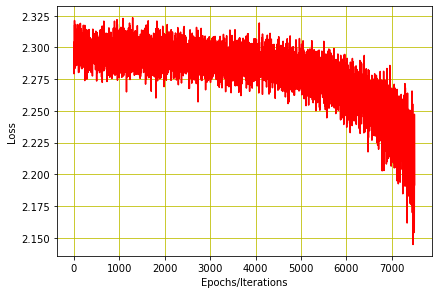

In [34]:
# 視覺化
plt.plot(loss_list, 'r')
plt.tight_layout()
plt.grid('True', color='y')
plt.xlabel("Epochs/Iterations")
plt.ylabel("Loss")
plt.show()

In [35]:
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for datas, labels in test_loader:
        outputs = model(datas)
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    acc = 100.0 * n_correct / n_samples
    print(f'accuracy = {acc}%')

accuracy = 32.65%
